# Measuring Image Similarity using Mutual Information 

Mutual information can be used to calculate the similarity between images and been applied to image registration of medical image. 

In this notebook, we hope to give you a practical understanding of mutual information as applied to images. 

If there is still confusion, we recommend this excellent paper of mutual information and it's use in medical image registration can be found [here](10.1109/TMI.2003.815867). 

## Getting Started

First we will need install some software and download an example image. 

To run the code, click the play icon in the left gutter of each cell or type Cmd/Ctrl+Enter to run the cell in place.

> This demo runs completely in your browser, you don't need to install anything locally

Download the HEMnet Github Repository 

In [1]:
# !git clone https://github.com/BiomedicalMachineLearning/HEMnet.git
!git clone --single-branch --branch tutorials https://github.com/BiomedicalMachineLearning/HEMnet.git

Cloning into 'HEMnet'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 752 (delta 84), reused 60 (delta 24), pack-reused 596
Receiving objects: 100% (752/752), 786.10 MiB | 26.52 MiB/s, done.
Resolving deltas: 100% (298/298), done.
Checking out files: 100% (113/113), done.


Install software packages

In [2]:
# Install openslide to open Whole Slide Images (WSIs)
!apt update && apt install -y openslide-tools
!pip install openslide-python

# Install SimpleITK for image registration - necessary for HEMnet package but not specifically for this tutorial
!pip install SimpleITK

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]


Download a slide to use as an example

We will use the `Leica-1` slide from openslide's demos. You can view the slide here: https://openslide.org/demo/

In [3]:
!wget http://openslide.cs.cmu.edu/download/openslide-testdata/Leica/Leica-1.scn

--2020-12-21 02:28:07--  http://openslide.cs.cmu.edu/download/openslide-testdata/Leica/Leica-1.scn
Resolving openslide.cs.cmu.edu (openslide.cs.cmu.edu)... 128.2.209.93
Connecting to openslide.cs.cmu.edu (openslide.cs.cmu.edu)|128.2.209.93|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 291812870 (278M) [image/tiff]
Saving to: ‘Leica-1.scn’

Leica-1.scn         100%[===================>] 278.29M  2.81MB/s    in 97s     

2020-12-21 02:29:44 (2.87 MB/s) - ‘Leica-1.scn’ saved [291812870/291812870]



Import the python packages we need, including HEMnet.

In [4]:
import glob
import importlib
import io
from ipywidgets import interact
from ipywidgets import fixed
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
from scipy import ndimage
import seaborn as sns
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage import morphology
import sys
import time
import warnings

In [5]:
# Import HEMnet package
BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.joinpath('HEMnet/HEMnet')
sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *

In [6]:
# SLIDES_PATH = Path('.')

# For the purpose of demonstration we will process the image at 1x magnfication
# This should speed up the processing and plotting steps
MAG = 1
VERBOSE = True

# Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi, bbox_inches = 'tight')
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

Let's have a look at the image we downloaded

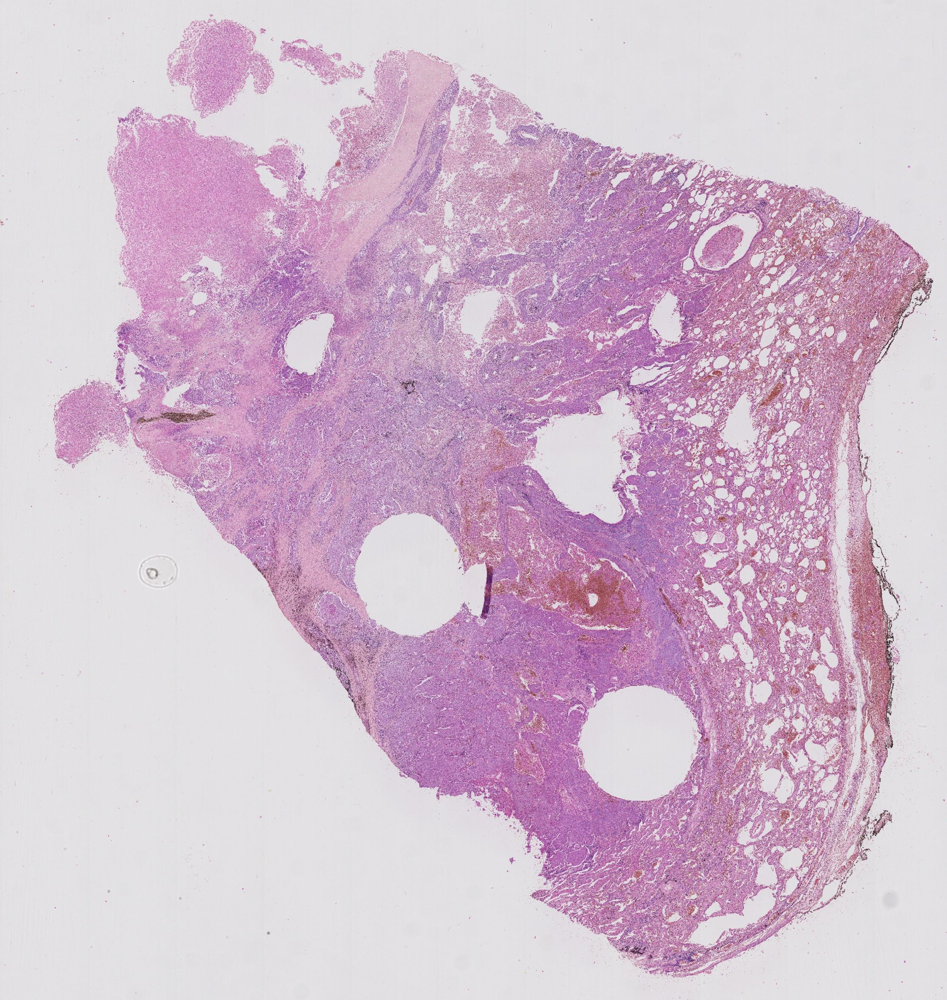

In [7]:
# Load Slide
he_slide = open_slide('Leica-1.scn')
he = read_slide_at_mag(he_slide, 1).convert('RGB')
# Crop to tissue
he_cropped = he.crop((570, 1770, 2350, 3650))
thumbnail(he_cropped)

## Measuring Information ( Entropy )

Before we tackle mutual information, we should first consider *how to measure information*? 

In 1928, Hartley derived quantitative measure of information that formed the foundation of many future methods. Hartley considered a message a sequence of symbols. 

For example, say we were to write a message in morse code. We would have $3$ symbols at our disposal: the dot (.), the dash (-) and space ( ). Assuming any arbitrary sequence is a valid message then, for a two symbol message, we have $3^2$ or $9$ different sequences. In this way, a sequence of $n$ symbols could make $3^n$ different messages.

Hartley considered $s$ as the number of possible symbols and hence we could make $s^n$ different messages. This could be directly used a measure of information but this would mean that information increases exponentially with the length of message which was not realistic to Hartley. Instead, he considered a information measure of practical engineering value to increase linearly with the message length $n$. To do so, Hartley derived his measure of information $H$ as $H=\log_{} s^n = n\log_{} s$

Using Hartley's measure we can see that as the number of possible messages $S^n$ increases, so too does the information you get from a message.

**Shannon Entropy**

Shannon improved upon Hartley's measure by weighting the information of each message by the probability of it being received. Hence, the rare a message or event is, the more information you get. 

We can calculate the *shannon entropy* for an image by examing the probability distribution of gray value - the image histogram. 

We use the formula $H=-\sum_{i=1}^{n-1} p_{i}\log_{b} p_{i}$ <br>
$_{n}$ is the number of gray levels. We will use 8-bit images so it is 256. <br>
$p_{i}$ is the probability of a pixel having a certain gray level. We can estimate this by counting the number of times the particular gray value occurs in the image and dividing it by the total number of pixels. <br> 
$b$ is the base of the logarithm. This determines the size of a unit of information. Here we will use 2, which is used in skimage. 

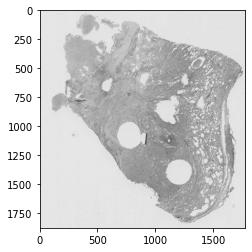

In [8]:
he_gray = he_cropped.convert('L')   # Convert to grayscale
img = np.asarray(he_gray)   # Convert to numpy array for easier processing
plt.imshow(img, cmap='gray');

Let's plot a histogram to visualise the probability distribution of the gray values. 

We have $_{n}=256$ gray values.
We want the y-axis to be the probability density function at each bin so we will set the `density` as `True`. 

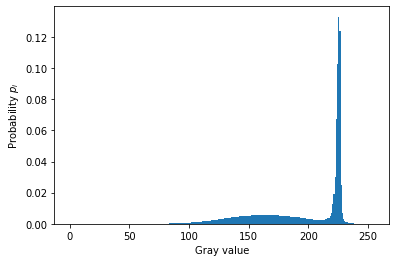

In [9]:
hist, bin_edges = np.histogram(img.ravel(), bins=255, range=(0, 255), density=True)
plt.hist(bin_edges[:-1], bin_edges, weights=hist)
plt.ylabel("Probability $p_{i}$")
plt.xlabel("Gray value");

Let's calculate shannon entropy using our histogram values

In [10]:
entropy = 0
for p in hist:
  if p > 0:
    entropy += p * np.log2(p)
print(-entropy)

5.727595528539628


Let's check this against skimage's implementation of shannon entropy

In [11]:
from skimage.measure import shannon_entropy
shannon_entropy(img)

5.727595528539627

We can see that the log scaling causes smaller $p_{i}$ values to have a greater contribution to the final entropy of the image. 

In [12]:
entropies = []
for p in hist: 
  if p > 0: 
    entropies.append(- p * np.log2(p))
  else:
    entropies.append(0)

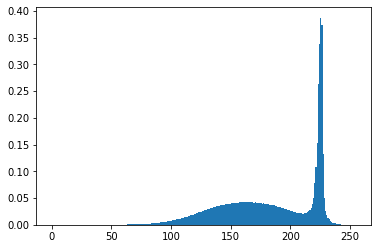

In [13]:
plt.hist(bin_edges[:-1], bin_edges, weights=entropies);

Can we make an image with no entropy?

Let's make an image with just a single pixel value, say $128$.

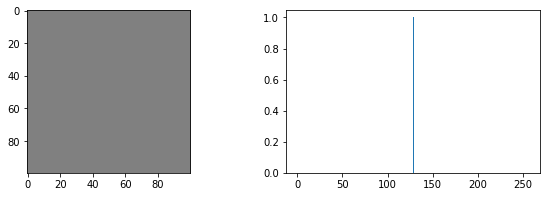

In [22]:
img_128 = np.full(shape=(100, 100), fill_value=128)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axs[0].imshow(img_128, cmap='gray', vmin=0, vmax=255)
axs[1].hist(img_128.ravel(), bins=256, range=(0, 256), density=True);

In [15]:
shannon_entropy(img_128)

0.0

What about an image with the maximum entropy? 

To do this, let's make an image with an equal number of pixels at all grey levels. 

In [16]:
img_ramp = np.zeros((256, 256))
img_ramp[:] = np.linspace(start=0, stop=255, num=256)[:, None]

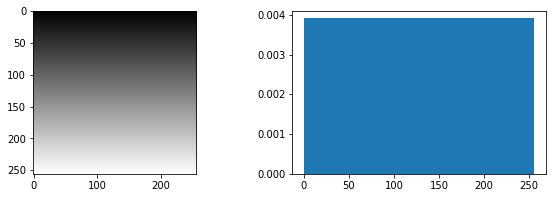

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
axs[0].imshow(img_ramp, cmap='gray', vmin=0, vmax=255)
axs[1].hist(img_ramp.ravel(), bins=256, range=(0, 256), density=True);

In [18]:
shannon_entropy(img_ramp)

8.0

## Measuring Image Alignment ( Mutual Information)

Suppose we had two images that were aligned through some registration algorithm. How would we measure how well these images are aligned? 

To answer this question, let's compare the original image with one captured in a different modality like immunohistochemitry (IHC). We don't have a real IHC couterpart for this image so we'll simulate it.  

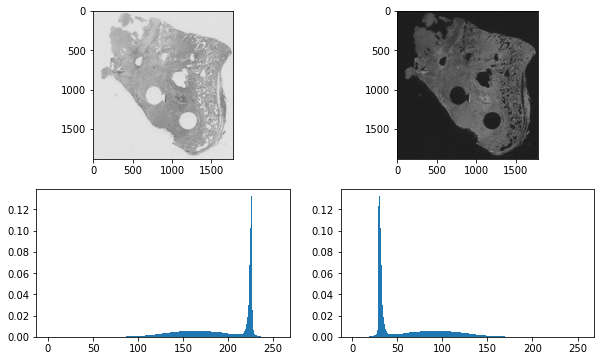

In [50]:
# Invert image
img_diff_modality = 255 - img

# Plot inverted image alongside original image
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
axs[0, 0].imshow(img, cmap='gray', vmin=0, vmax=255)
axs[0, 1].imshow(img_diff_modality, cmap='gray', vmin=0, vmax=255)
axs[1, 0].hist(img.ravel(), bins=256, range=(0, 256), density=True)
axs[1, 1].hist(img_diff_modality.ravel(), bins=256, range=(0, 256), density=True);

Looking at these images we can see that they are perfectly aligned yet the individual histograms are different. 

Instead, it is more informative to look the relationship of pixels between these two images.

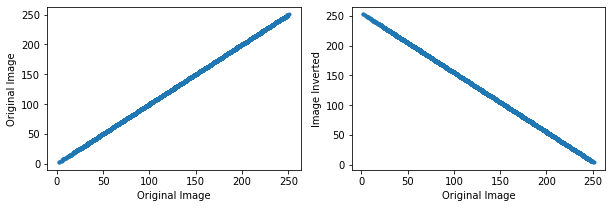

In [51]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3))
axs[0].plot(img.ravel(), img.ravel(), '.')
axs[1].plot(img.ravel(), img_diff_modality.ravel(), '.')

for ax in axs:
    ax.set_xlabel('Original Image',)

axs[0].set_ylabel('Original Image')
axs[1].set_ylabel('Image Inverted');

In [40]:
# Apply transformations to images
img_rot15 = ndimage.rotate(img, -15, cval = 225, reshape = False)
img_shift = ndimage.shift(img, (100, 100), cval = 225)
img_invert = 255 - img

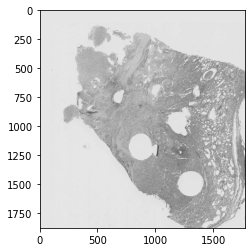

In [38]:
plt.imshow(img_shift, cmap = 'gray')

In [ ]:
# fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (20,10))
# axs[0,0].imshow(img_gray_np, cmap = 'gray', interpolation = 'bicubic')
# axs[0,1].hist(img_gray_np.ravel(), bins = 256)
# axs[1,0].imshow(img_gray_np_rot30, cmap = 'gray', interpolation = 'bicubic')
# axs[1,1].hist(img_gray_np_rot30.ravel(), bins = 256)
# axs[2,0].imshow(img_gray_np_shift, cmap = 'gray', interpolation = 'bicubic')
# axs[2,1].hist(img_gray_np_shift.ravel(), bins = 256)
# axs[0,1].set_ylim([0, 100000])
# axs[1,1].set_ylim([0, 100000])
# axs[2,1].set_ylim([0, 100000])
# fig.tight_layout()
# plt.show()

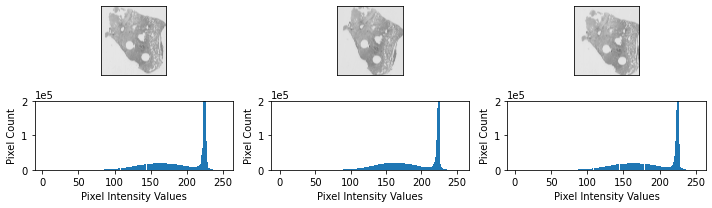

In [42]:
# Plot original, rotated 30 degress and shifted images with histograms
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,3))
# Plot images 
axs[0,0].imshow(img, cmap='gray', interpolation='bicubic')
axs[0,1].imshow(img_rot15, cmap='gray', interpolation='bicubic')
axs[0,2].imshow(img_shift, cmap='gray', interpolation='bicubic')
# Remove ticks from image plots
for ax in axs[0, :]:
    ax.set_xticks([])
    ax.set_yticks([])

# Plot histograms
axs[1,0].hist(img.ravel(), bins=256)
axs[1,1].hist(img_rot15.ravel(), bins=256)
axs[1,2].hist(img_shift.ravel(), bins=256)
# Limit y range so that more histogram values are visible, not just the peaks
for ax in axs[1, :]:
    ax.set_ylim([0, 200000])
    ax.ticklabel_format(scilimits=(-5, 5))
    ax.set_xlabel('Pixel Intensity Values')
    ax.set_ylabel('Pixel Count')
fig.tight_layout()

In [ ]:
# Plot pixel intensities against original pixel intensities
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 3.5))
axs[0].plot(img_gray_np.ravel(), img_gray_np.ravel(), '.', alpha = 0.10)
axs[1].plot(img_gray_np.ravel(), img_gray_np_rot30.ravel(), '.', alpha = 0.10)
axs[2].plot(img_gray_np.ravel(), img_gray_np_shift.ravel(), '.', alpha = 0.10)

for ax in axs:
    ax.set_xlabel('Original Image Pixel Intensity')
    ax.grid(True, 'both')

axs[0].set_ylabel('Original Image Pixel Intensity')    
axs[1].set_ylabel('Image Rotated Pixel Intensity')
axs[2].set_ylabel('Image Shifted Pixel Intensity')
fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
verbose_save_fig(fig, OUTPUT_PATH.joinpath('2065_T_og_rot30_shift_scatterplot.png'))

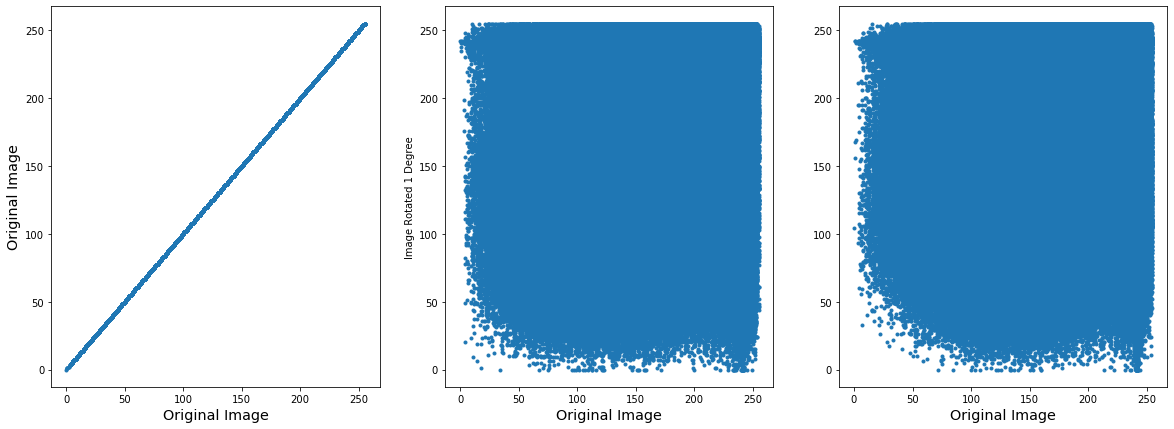

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 7))
axs[0].plot(img_gray_np.ravel(), img_gray_np.ravel(), '.')
axs[1].plot(img_gray_np.ravel(), img_gray_np_rot1.ravel(), '.')
axs[2].plot(img_gray_np.ravel(), img_gray_np_rot30.ravel(), '.')

for ax in axs:
    ax.set_xlabel('Original Image', size = 'x-large')

axs[0].set_ylabel('Original Image', size = 'x-large')
axs[1].set_ylabel('Image Rotated 1 Degree')
plt.show()

In [ ]:
# Compute 2D histograms
hist_2d_og_og, x_edges, y_edges = np.histogram2d(img_gray_np.ravel(), img_gray_np.ravel(), bins = 20)
hist_2d_rot30_og, x_edges, y_edges = np.histogram2d(img_gray_np.ravel(), img_gray_np_rot30.ravel(), bins = 20)
hist_2d_shift_og, x_edges, y_edges = np.histogram2d(img_gray_np.ravel(), img_gray_np_shift.ravel(), bins = 20)

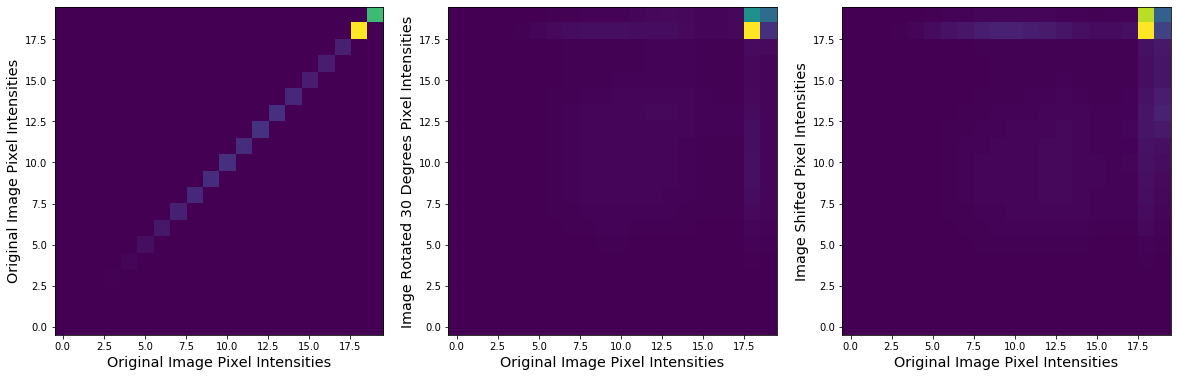

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 7))
axs[0].imshow(hist_2d_og_og.T, origin = 'lower')
axs[1].imshow(hist_2d_rot30_og, origin = 'lower')
axs[2].imshow(hist_2d_shift_og, origin = 'lower')

for ax in axs:
    ax.set_xlabel('Original Image Pixel Intensities', size = 'x-large')

axs[0].set_ylabel('Original Image Pixel Intensities', size = 'x-large')
axs[1].set_ylabel('Image Rotated 30 Degrees Pixel Intensities', size = 'x-large')
axs[2].set_ylabel('Image Shifted Pixel Intensities', size = 'x-large')

plt.show()

In [ ]:
def mutual_info_histogram(fixed_img, moving_img, log = False):
    hist_2d, x_edges, y_edges = np.histogram2d(fixed_img.ravel(), moving_img.ravel(), bins = 20)
    if log:
        hist_2d_log = np.zeros(hist_2d.shape)
        non_zeros = hist_2d != 0
        hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
        return hist_2d_log
    return hist_2d

In [ ]:
def plot_log_histogram(x_img, y_img, axes):
    hist_2d = mutual_info_histogram(x_img, y_img, log = True)
    return axes.imshow(hist_2d.T, origin = 'lower', interpolation='none')

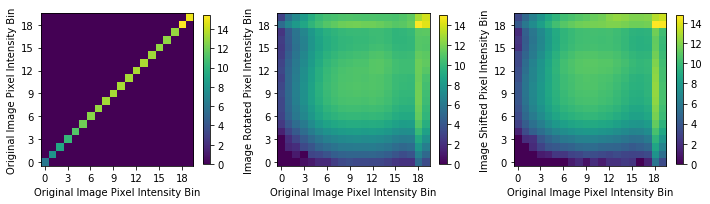

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 3.5))
plot_gray = plot_log_histogram(img_gray_np, img_gray_np, axs[0])
plot_rot30 = plot_log_histogram(img_gray_np, img_gray_np_rot30, axs[1])
plot_shift = plot_log_histogram(img_gray_np, img_gray_np_shift, axs[2])

#Add a colorbar to each plot
for i, plot in enumerate([plot_gray, plot_rot30, plot_shift]):
    fig.colorbar(plot, ax=axs[i], shrink=0.65, ticks=np.arange(0, 20, 2))
    axs[i].set_xticks(np.arange(0, 20, 3))
    axs[i].set_yticks(np.arange(0, 20, 3))

for ax in axs:
    ax.set_xlabel('Original Image Pixel Intensity Bin')

axs[0].set_ylabel('Original Image Pixel Intensity Bin')
axs[1].set_ylabel('Image Rotated Pixel Intensity Bin')
axs[2].set_ylabel('Image Shifted Pixel Intensity Bin')

fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
verbose_save_fig(fig, OUTPUT_PATH.joinpath('2065_T_og_rot30_shift_2D_hist_log.svg'))

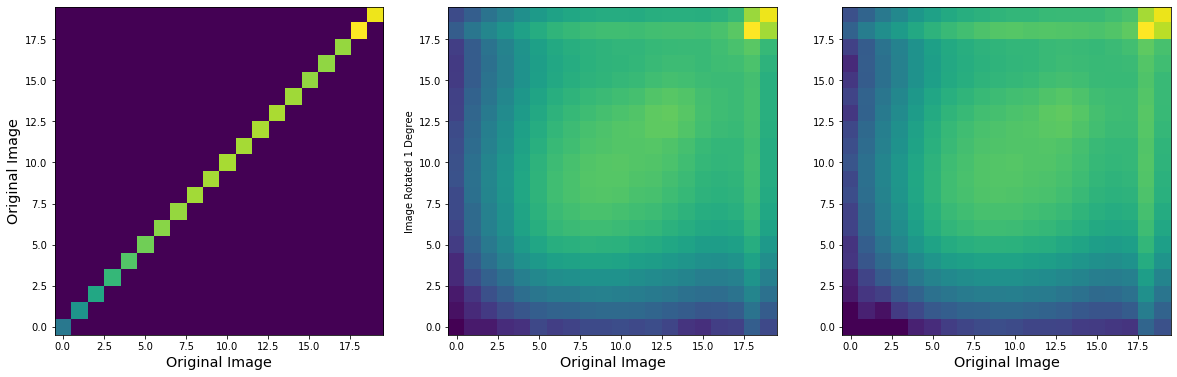

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 7))
plot_log_histogram(img_gray_np, img_gray_np, axs[0])
plot_log_histogram(img_gray_np, img_gray_np_rot1, axs[1])
plot_log_histogram(img_gray_np, img_gray_np_rot5, axs[2])

for ax in axs:
    ax.set_xlabel('Original Image', size = 'x-large')

axs[0].set_ylabel('Original Image', size = 'x-large')
axs[1].set_ylabel('Image Rotated 1 Degree')
plt.show()

In [ ]:
#Bin counts to probability values
hist_2d_og_og_norm = hist_2d_og_og / float(np.sum(hist_2d_og_og))
hist_2d_rot30_og_norm = hist_2d_rot30_og / float(np.sum(hist_2d_rot30_og))
hist_2d_shift_og_norm = hist_2d_shift_og / float(np.sum(hist_2d_shift_og))

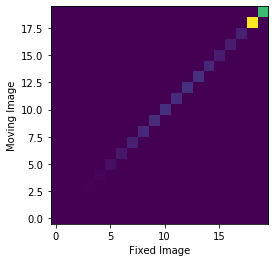

In [ ]:
plot_mutual_info_histogram(hist_2d_og_og_norm)

In [ ]:
#Calculate marginal probability distributions
px = np.sum(hist_2d_og_og_norm, axis = 1) #marginal for x over y
py = np.sum(hist_2d_og_og_norm, axis = 0)

In [ ]:
px

array([3.12139392e-05, 1.89739390e-04, 6.69257876e-04, 1.85054068e-03,
       5.23218001e-03, 1.17776720e-02, 2.16255082e-02, 2.89044954e-02,
       3.79770886e-02, 4.17605024e-02, 4.39224069e-02, 4.19753809e-02,
       4.68569050e-02, 4.54686279e-02, 3.62963181e-02, 2.62686948e-02,
       2.53790006e-02, 2.90391096e-02, 3.29335816e-01, 2.25439541e-01])

In [ ]:
py

array([3.12139392e-05, 1.89739390e-04, 6.69257876e-04, 1.85054068e-03,
       5.23218001e-03, 1.17776720e-02, 2.16255082e-02, 2.89044954e-02,
       3.79770886e-02, 4.17605024e-02, 4.39224069e-02, 4.19753809e-02,
       4.68569050e-02, 4.54686279e-02, 3.62963181e-02, 2.62686948e-02,
       2.53790006e-02, 2.90391096e-02, 3.29335816e-01, 2.25439541e-01])

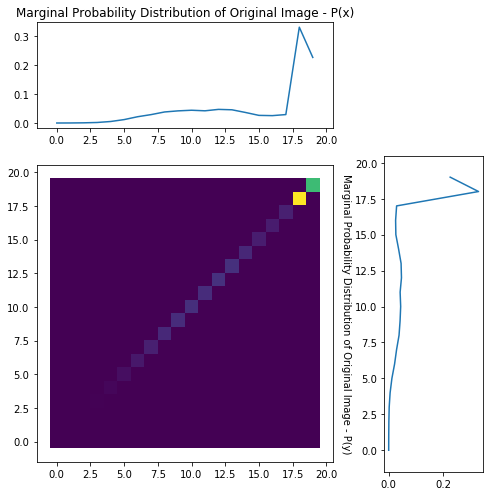

In [ ]:
plt.figure(figsize = (7,7))
gs = gridspec.GridSpec(2,2, width_ratios = [3, 1], height_ratios = [1, 3])
ax = plt.subplot(gs[1, 0])
axt = plt.subplot(gs[0,0], sharex = ax)
axt.set_title("Marginal Probability Distribution of Original Image - P(x)")
axr = plt.subplot(gs[1,1], sharey = ax)
axr.set_ylabel("Marginal Probability Distribution of Original Image - P(y)", rotation = -90, va = 'top')
ax.imshow(hist_2d_og_og_norm.T, origin = 'lower')
#plot_log_histogram(img_gray_np, img_gray_np, ax)
axt.plot(px)
axr.plot(py, range(20))
plt.tight_layout()

In [ ]:
px_py = px[:, None]*py[None, :]

In [ ]:
def plot_px_py(hist_2d, axes):
    px = np.sum(hist_2d, axis = 1) #marginal for x over y
    py = np.sum(hist_2d, axis = 0)
    px_py = px[:, None]*py[None, :]
    axes.imshow(px_py, origin = 'lower')

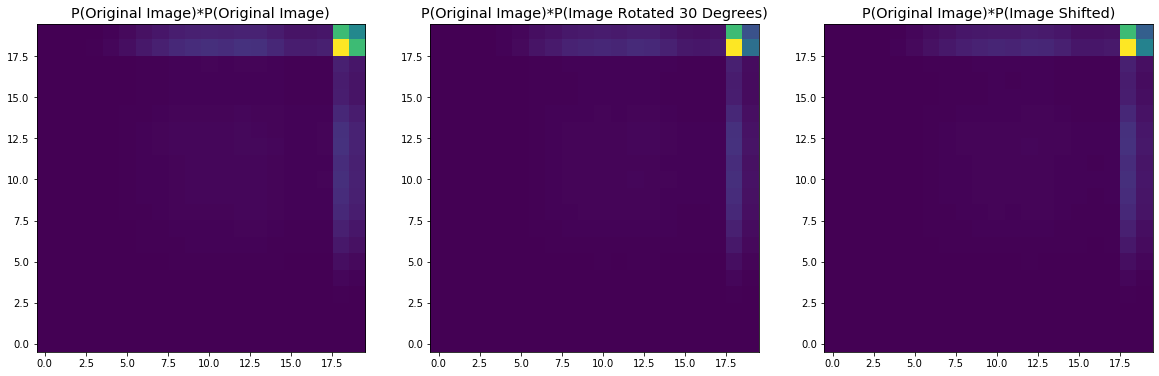

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 7))
plot_px_py(hist_2d_og_og_norm, axs[0])
plot_px_py(hist_2d_rot30_og_norm, axs[1])
plot_px_py(hist_2d_shift_og_norm, axs[2])

axs[0].set_title('P(Original Image)*P(Original Image)', size = 'x-large')
axs[1].set_title('P(Original Image)*P(Image Rotated 30 Degrees)', size = 'x-large')
axs[2].set_title('P(Original Image)*P(Image Shifted)', size = 'x-large')

plt.show()

In [ ]:
mutual_information(hist_2d_og_og)

2.2083618797452345

In [ ]:
mutual_information(hist_2d_rot30_og)

0.17102837861859482

In [ ]:
mutual_information(hist_2d_shift_og)

0.14745153589258586

In [ ]:
calculate_mutual_info(img_gray_np, img_gray_np_rot1)

0.5825031359598887

In [ ]:
img_gray_np_rot1 = ndimage.rotate(img_gray_np, -1, cval = 242, reshape = False)

In [ ]:
angles = np.linspace(0,90, 910)

In [ ]:
mutual_infos = []
for angle in angles:
    img_rot = ndimage.rotate(img_gray_np, angle, cval = 242, reshape = False)
    mutual_infos.append(calculate_mutual_info(img_gray_np, img_rot))

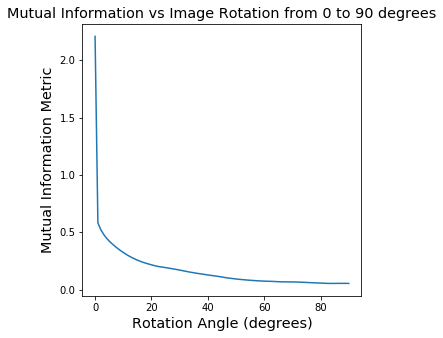

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(angles, mutual_infos)
ax.set_xlabel('Rotation Angle (degrees)', size = 'x-large')
ax.set_ylabel('Mutual Information Metric', size = 'x-large')
ax.set_title('Mutual Information vs Image Rotation from 0 to 90 degrees', size = 'x-large')
plt.show()